# Exploring Anomaly Detection in Time Series Data


This notebook is used to explore a single time series with a known anomaly.  Future work will include training a model on training data followed by application of the model to testing data.  I also plan to implement more sophisticated techniques.

Data is from the UCR time series collection, downloaded on October 20, 2016.  http://www.cs.ucr.edu/~eamonn/time_series_data/

## Set up the Workspace

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
rcParams.update({'font.size': 10, 'axes.facecolor':[0.95, 0.95, 0.95]})

## Define Functions

In [2]:
# Moving average
# args = series (series) and window size (win_size)
# returns moving average of series as a new series with the same indices
def ma(series, win_size):
    return pd.Series(data=np.convolve(a=series, v=np.ones(int(win_size))/float(win_size), mode='same'), index=series.index)

In [3]:
# Z-Score
def z_score(ts):
    return (ts - ts.mean())/ts.std()

In [4]:
# Anomaly thresholds
# N is the number of standard deviations (see standard normal distribution plot)
# lam (lambda) is a weighting factor on (0,1].

N = 3

def threshold(series, lam):
    upper = pd.Series(data=(series.mean() + (N * series.std() * (lam / (2-lam)) ** 0.5)), index=series.index)
    lower = pd.Series(data=(series.mean() - (N * series.std() * (lam / (2-lam)) ** 0.5)), index=series.index)
    return upper, lower

## Load the Data

In [5]:
# Get the test data from file
data = pd.read_csv('RefrigerationDevices_TEST.csv', header=None, index_col=False)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,1,1.06340,1.06340,1.06340,1.06340,1.06340,-0.630320,-0.86128,-0.86128,-0.86128,...,1.06340,1.06340,1.06340,1.06340,0.75542,-0.78429,-0.93826,-0.86128,-0.86128,-0.93826
1,1,-0.95341,-0.87025,0.62656,2.20650,1.87390,1.541300,1.54130,1.54130,1.20870,...,-0.87025,-0.87025,-0.95341,-0.87025,-0.87025,-0.87025,-0.95341,-0.87025,-0.87025,1.20870
2,1,1.09040,0.77728,1.09040,1.09040,1.09040,0.777280,0.30759,-0.86665,-0.94494,...,-0.94494,-0.86665,0.30759,1.09040,1.09040,1.09040,1.09040,1.09040,1.09040,0.77728
3,1,-0.84982,-0.84982,-0.92679,-0.84982,-0.84982,0.073874,1.07450,1.07450,1.07450,...,-0.92679,-0.84982,-0.84982,-0.92679,-0.84982,-0.84982,-0.92679,-0.77284,1.07450,1.07450
4,1,-0.90531,-0.43298,1.14150,1.14150,1.14150,1.141500,0.82659,1.14150,1.14150,...,-0.82659,-0.90531,-0.82659,-0.82659,-0.90531,-0.82659,-0.90531,-0.82659,-0.82659,-0.90531


In [6]:
data.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
370,3,-0.36130,-0.36130,0.066555,-0.36130,-0.36130,0.066555,-0.36130,0.066555,-0.36130,...,0.066555,-0.36130,0.066555,0.066555,-0.36130,0.066555,-0.36130,0.066555,0.066555,-0.36130
371,3,0.26593,-0.32441,0.265930,-0.32441,0.26593,-0.324410,0.26593,-0.324410,0.26593,...,-0.324410,0.26593,-0.324410,-0.324410,0.26593,-0.324410,-0.32441,0.265930,-0.324410,0.26593
372,3,-0.30926,-0.30926,0.270600,-0.30926,-0.30926,0.270600,-0.30926,-0.309260,0.27060,...,-0.309260,-0.30926,0.270600,-0.309260,-0.30926,0.270600,-0.30926,-0.309260,0.270600,-0.30926
373,3,-0.36006,-0.36006,0.240040,-0.36006,-0.36006,0.240040,-0.36006,0.240040,-0.36006,...,0.240040,-0.36006,-0.360060,0.240040,-0.36006,0.240040,-0.36006,0.240040,-0.360060,0.24004
374,3,-0.31519,0.27836,-0.315190,-0.31519,0.27836,-0.315190,-0.31519,0.278360,-0.31519,...,0.278360,-0.31519,-0.315190,0.278360,-0.31519,0.278360,-0.31519,-0.315190,0.278360,-0.31519


In [7]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
count,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,...,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000
mean,2.000000,0.027459,0.062137,0.100354,0.116296,0.065281,0.064404,0.053072,0.034777,0.046943,...,0.017496,0.050650,0.054663,0.044923,-0.008839,0.004448,-0.053666,-0.064703,-0.047608,-0.125146
std,0.817587,0.939829,0.959107,0.970758,1.019629,1.001533,0.970447,0.968397,0.957330,1.004987,...,0.977092,1.003816,1.004774,0.997198,1.038120,1.018113,0.986914,0.963848,0.977269,0.946723
min,1.000000,-1.885000,-1.885000,-1.885000,-1.424800,-1.990600,-1.598900,-1.598900,-1.598900,-1.598900,...,-2.139600,-2.218000,-2.218000,-2.218000,-2.218000,-2.218000,-2.218000,-2.139600,-2.218000,-2.218000
25%,1.000000,-0.706685,-0.705460,-0.710545,-0.726715,-0.738290,-0.719040,-0.733365,-0.715200,-0.740080,...,-0.712785,-0.712065,-0.702380,-0.732550,-0.740305,-0.736840,-0.740670,-0.743040,-0.744750,-0.760085
50%,2.000000,-0.480700,-0.432980,-0.411650,-0.424290,-0.473590,-0.473780,-0.440930,-0.480700,-0.503270,...,-0.505510,-0.482890,-0.501580,-0.493570,-0.519810,-0.523050,-0.544730,-0.556990,-0.549680,-0.569060
75%,3.000000,0.998180,1.043350,1.035450,1.086150,1.016700,1.010650,0.986230,0.936630,1.024950,...,0.946440,0.982605,0.985100,0.978695,0.966200,0.942650,0.784700,0.759020,0.840200,0.698340
max,3.000000,2.551500,2.338600,2.459600,3.877400,2.689600,2.378100,2.378100,2.452900,3.717300,...,3.314100,3.616700,3.287000,2.904300,4.524000,4.524000,4.524000,3.993800,3.632800,3.126300


In [8]:
# The data are in rows, with the first column as the class names (1, 2, 3)
# Column values are time data, so transpose to make analysis with pandas easier.
data = data.transpose()
print(data.ix[:5,:7])

        0        1        2        3        4        5        6        7
0  1.0000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000
1  1.0634 -0.95341  1.09040 -0.84982 -0.90531 -1.34960 -1.07870  1.06240
2  1.0634 -0.87025  0.77728 -0.84982 -0.43298  0.72227  0.85813 -0.93999
3  1.0634  0.62656  1.09040 -0.92679  1.14150  0.72227  0.85813  1.06240
4  1.0634  2.20650  1.09040 -0.84982  1.14150 -1.34960 -1.07870 -0.93999
5  1.0634  1.87390  1.09040 -0.84982  1.14150  0.72227  0.85813  1.06240


In [9]:
class1 = data.ix[:,data.ix[0] == 1]
print(class1.ix[:5,:7])

        0        1        2        3        4        5        6        7
0  1.0000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000
1  1.0634 -0.95341  1.09040 -0.84982 -0.90531 -1.34960 -1.07870  1.06240
2  1.0634 -0.87025  0.77728 -0.84982 -0.43298  0.72227  0.85813 -0.93999
3  1.0634  0.62656  1.09040 -0.92679  1.14150  0.72227  0.85813  1.06240
4  1.0634  2.20650  1.09040 -0.84982  1.14150 -1.34960 -1.07870 -0.93999
5  1.0634  1.87390  1.09040 -0.84982  1.14150  0.72227  0.85813  1.06240


## Examine the data

In [10]:
# Specify the time series (column number)
ts = class1.ix[1:,3]

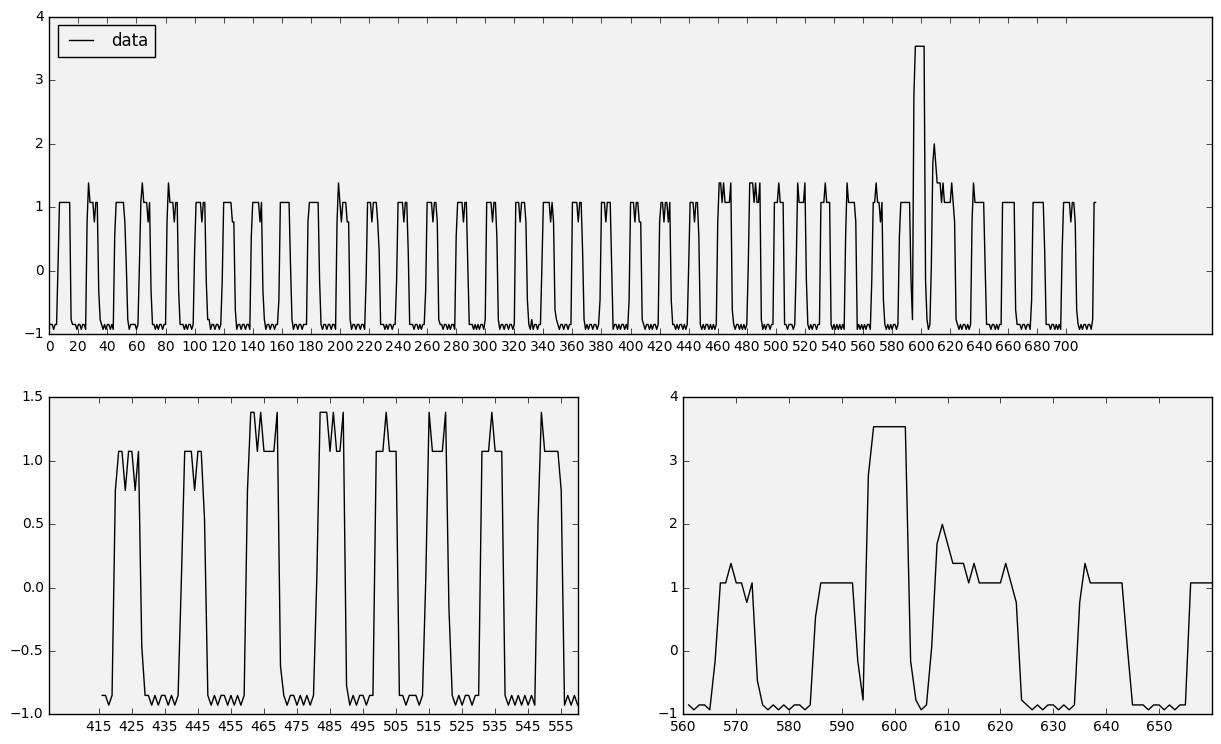

In [11]:
# Examine the time series

# Plot the whole series in upper plot and smaller portions in lower plots.
plot_range1 = [415,560]
plot_range2 = [560,660]

plt.figure(figsize=(15,9))
ax1 = plt.subplot(211)
plt.plot(ts, label='data', color='k')
ax1.legend(loc='upper left');
ax1.xaxis.set_ticks(np.arange(0, len(ts), 20));

ax3 = plt.subplot(223)
plt.plot(ts[plot_range1[0]:plot_range1[1]], label='data', color='k')
ax3.xaxis.set_ticks(np.arange(plot_range1[0], plot_range1[1], 10));

ax4 = plt.subplot(224)
plt.plot(ts[plot_range2[0]:plot_range2[1]], label='data', color='k')
ax4.xaxis.set_ticks(np.arange(plot_range2[0], plot_range2[1], 10));

plt.show()

In [12]:
# Check some series values

t_list = [150, 160, 170, 180, 458, 459, 468, 660]

print('Some data points at high and low values')
for t in t_list:
    print(ts[t])
print()
print('The mean of two low values')
print(np.mean([ts[458],ts[459]]))

Some data points at high and low values
-0.84982
1.0745
-0.84982
1.0745
-0.92679
-0.84982
1.0745
1.0745

The mean of two low values
-0.888305


The signal normally varies between about -0.89 and 1.0745.

There are some small spikes as well as an obvious anomaly.  The spikes are generally insignificant and create momentary negative changes in the data, but perhaps in a couple of instances the mean of the series is significantly affected, like between 460 and 490.  For these signals, the spikes create momentary positive changes in the series.  The large anomaly is at 600, and it affects the next signal in the series, presumably due to the drop in signal at about 595 that seems to over recover a couple of times before settling back at the nominal value of 1.0745.  The signal at 620 appears to be convolved with the previous anomaly, which gives it a longer frequency.  The signal appears fully recovered after 630.

I will first try simple limit checking to detect the anomalies, and then I will consider more sophisticated methods.

By checking the moving average, we can see how the spikes (and the big anomaly) affect the mean along the series.

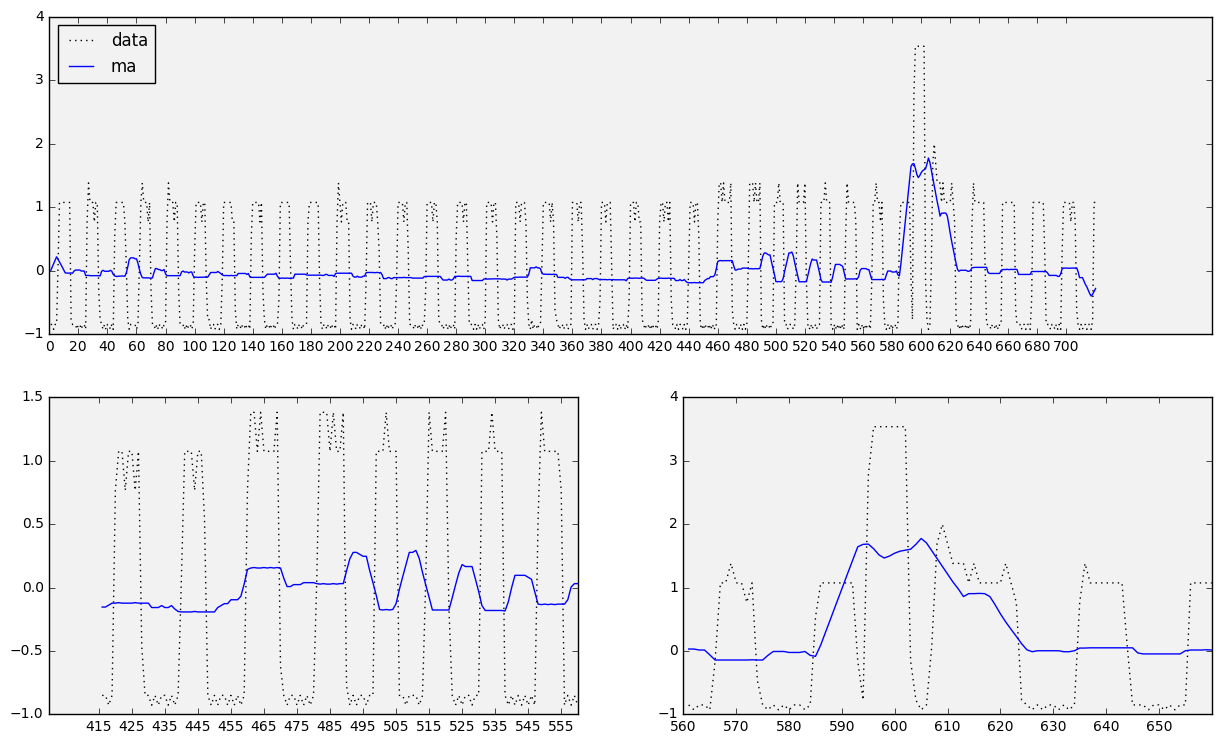

In [16]:
# Moving average of the original data
ts_ma = ma(ts, 20)


# Show the results
plt.figure(figsize=(15,9))
ax1 = plt.subplot(211)
plt.plot(ts, label='data', color='k', ls=':')
plt.plot(ts_ma, label='ma', color='b')
ax1.legend(loc='upper left');
ax1.xaxis.set_ticks(np.arange(0, len(ts), 20));

ax3 = plt.subplot(223)
plt.plot(ts[plot_range1[0]:plot_range1[1]], label='data', color='k', ls=':')
plt.plot(ts_ma[plot_range1[0]:plot_range1[1]], label='ma', color='b')
ax3.xaxis.set_ticks(np.arange(plot_range1[0], plot_range1[1], 10));

ax4 = plt.subplot(224)
plt.plot(ts[plot_range2[0]:plot_range2[1]], label='data', color='k', ls=':')
plt.plot(ts_ma[plot_range2[0]:plot_range2[1]], label='ma', color='b')
ax4.xaxis.set_ticks(np.arange(plot_range2[0], plot_range2[1], 10));

plt.show()

If all we cared about was the large anomaly, it might be sufficient to set upper and lower bounds on the data or on the moving average and test for values that exceed the threshold.  However, this may not be robust given this small sample of data, so let's look for ways of increasing sensitivity to the anomalies.

Differencing should provide more sensitivity.

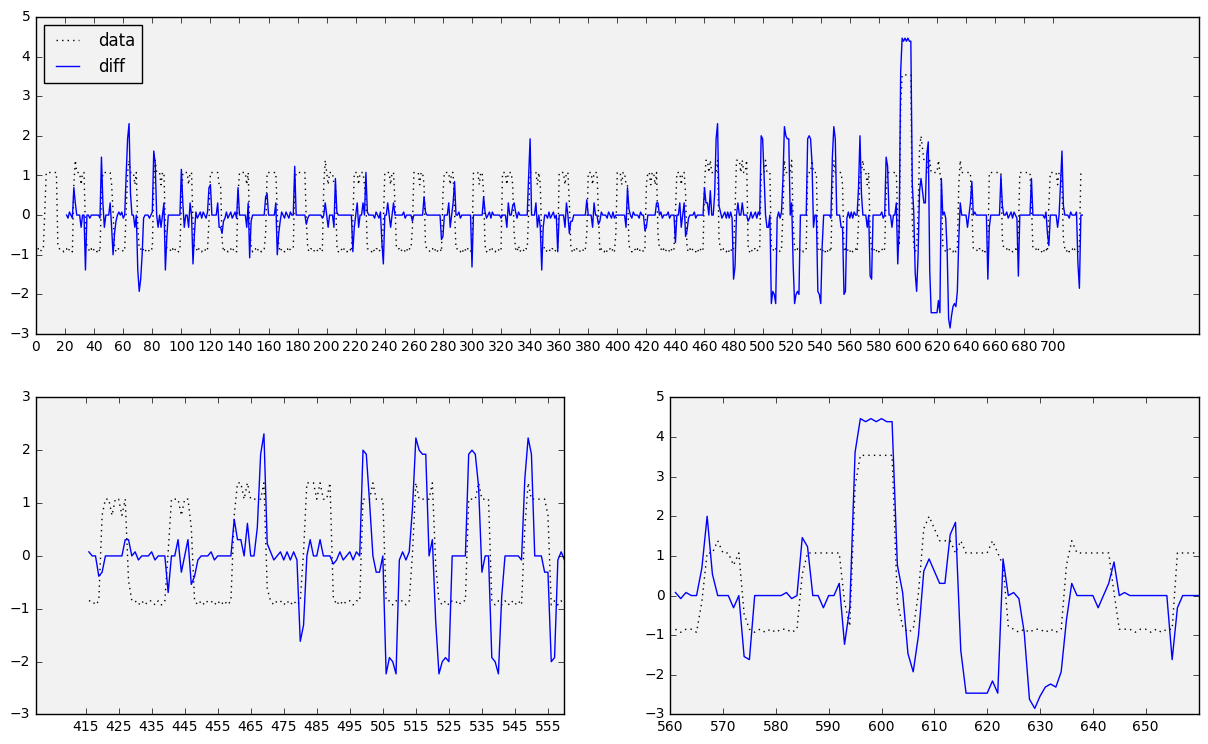

In [14]:
# Try differencing the original data
ts_diff = ts.diff(20)


# Show the results
plt.figure(figsize=(15,9))
ax1 = plt.subplot(211)
plt.plot(ts, label='data', color='k', ls=':')
plt.plot(ts_diff, label='diff', color='b')
ax1.legend(loc='upper left');
ax1.xaxis.set_ticks(np.arange(0, len(ts), 20));

ax3 = plt.subplot(223)
plt.plot(ts[plot_range1[0]:plot_range1[1]], label='data', color='k', ls=':')
plt.plot(ts_diff[plot_range1[0]:plot_range1[1]], label='diff', color='b')
ax3.xaxis.set_ticks(np.arange(plot_range1[0], plot_range1[1], 10));

ax4 = plt.subplot(224)
plt.plot(ts[plot_range2[0]:plot_range2[1]], label='data', color='k', ls=':')
plt.plot(ts_diff[plot_range2[0]:plot_range2[1]], label='diff', color='b')
ax4.xaxis.set_ticks(np.arange(plot_range2[0], plot_range2[1], 10));

plt.show()

The anomalies are more pronounced, but the differencing also amplifies other spikes that might not be significant (we might want to ignore them).  Using a simple limit check would potentially trigger at the wrong signals (like 60 and 340) when we are only interested in other ones (possibly 460 to 490, but definitely 600 to 620).  So differencing alone is not helpful here.

Differencing the MA values should yield a better separation of normal and anomalous signals.

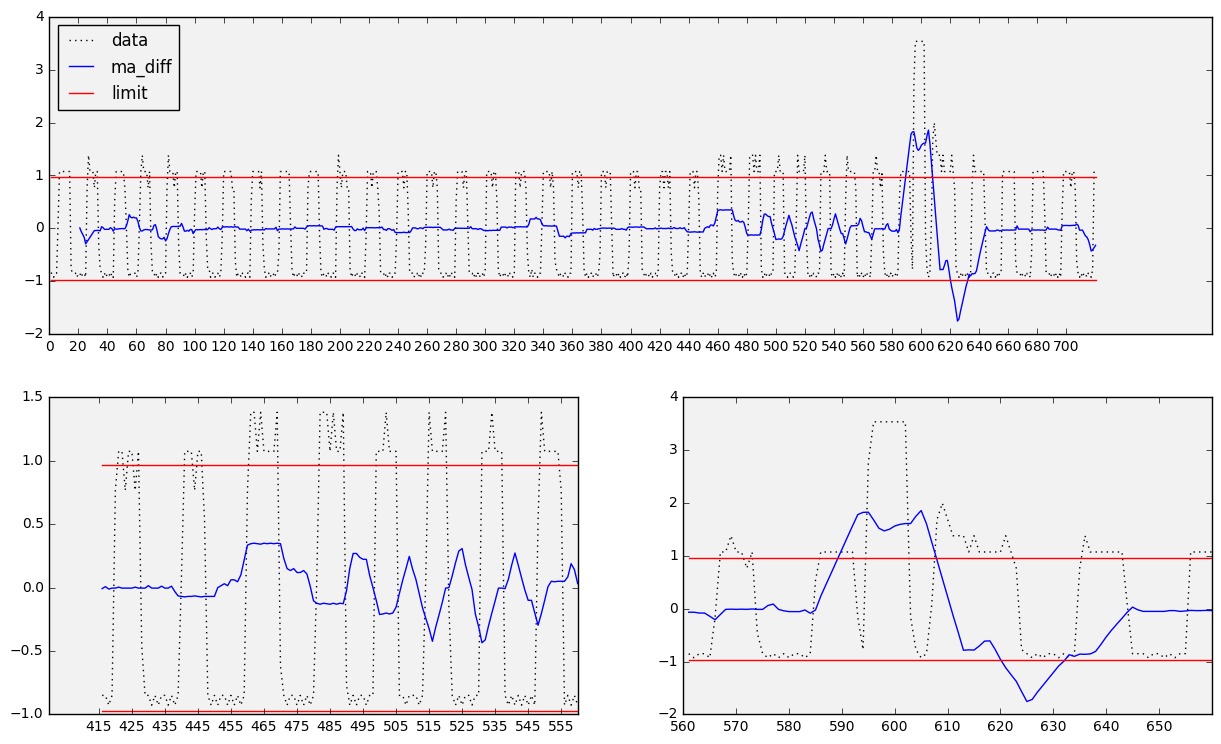

In [19]:
ts_ma_diff = ts_ma.diff(20)
ts_ma_diff_thresh = threshold(ts_ma_diff, 0.9)


# Show the results
plt.figure(figsize=(15,9))
ax1 = plt.subplot(211)
plt.plot(ts, label='data', color='k', ls=':')
plt.plot(ts_ma_diff, label='ma_diff', color='b')
plt.plot(ts_ma_diff_thresh[0], label='limit', color='r')
plt.plot(ts_ma_diff_thresh[1], label='_nolabel_', color='r')
ax1.legend(loc='upper left');
ax1.xaxis.set_ticks(np.arange(0, len(ts), 20));

ax3 = plt.subplot(223)
plt.plot(ts[plot_range1[0]:plot_range1[1]], label='data', color='k', ls=':')
plt.plot(ts_ma_diff[plot_range1[0]:plot_range1[1]], label='ma_diff', color='b')
plt.plot(ts_ma_diff_thresh[0][plot_range1[0]:plot_range1[1]], label='limit', color='r')
plt.plot(ts_ma_diff_thresh[1][plot_range1[0]:plot_range1[1]], label='_nolabel_', color='r')
ax3.xaxis.set_ticks(np.arange(plot_range1[0], plot_range1[1], 10));

ax4 = plt.subplot(224)
plt.plot(ts[plot_range2[0]:plot_range2[1]], label='data', color='k', ls=':')
plt.plot(ts_ma_diff[plot_range2[0]:plot_range2[1]], label='ma_diff', color='b')
plt.plot(ts_ma_diff_thresh[0][plot_range2[0]:plot_range2[1]], label='limit', color='r')
plt.plot(ts_ma_diff_thresh[1][plot_range2[0]:plot_range2[1]], label='_nolabel_', color='r')
ax4.xaxis.set_ticks(np.arange(plot_range2[0], plot_range2[1], 10));

plt.show()

Differencing the MA values did not provide much of an advantage over the MA values alone (not the differenced values).  The large anomaly is detectible in each case, and the small spikes between 460 and 490 remain undetected.  If the limits were tightened (closer to the ma_diff mean), we would increase false detections of good signals.

Z-score can also be used to highlight anomalous data by amplifying signals.

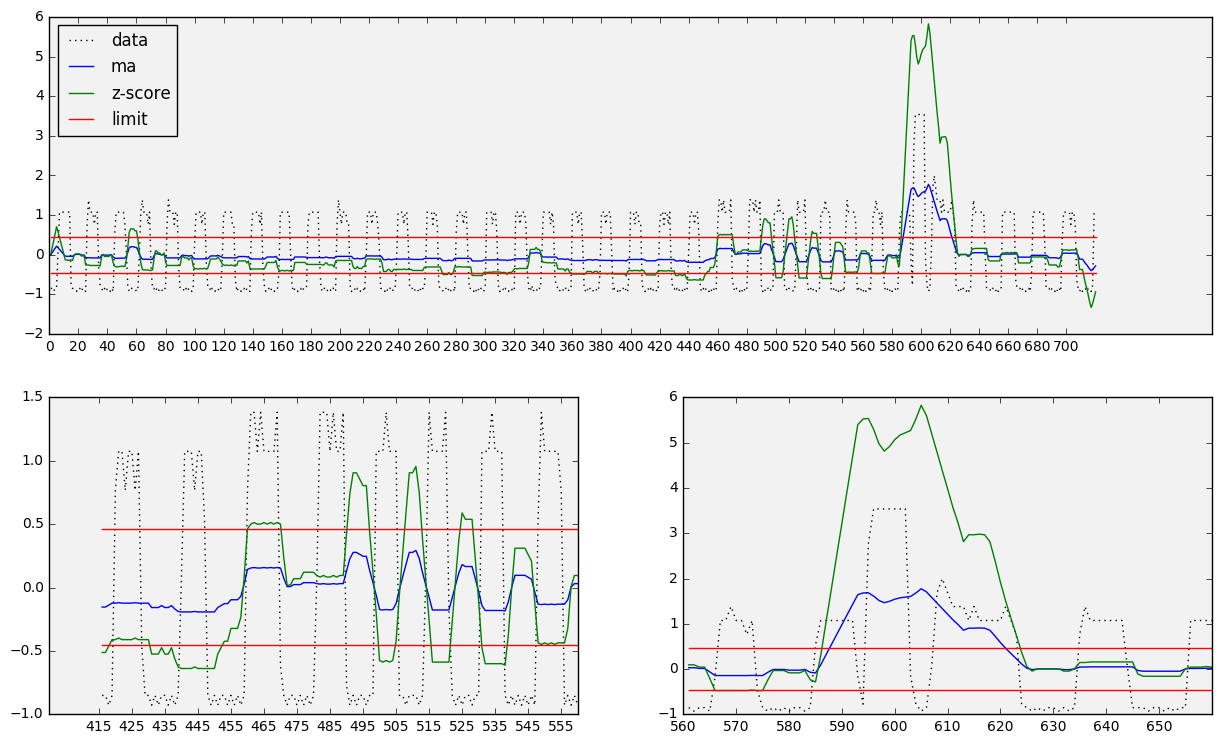

In [20]:
ts_ma_z = z_score(ts_ma)
ts_ma_thresh = threshold(ts_ma, 0.4)


# Show the results
plt.figure(figsize=(15,9))
ax1 = plt.subplot(211)
plt.plot(ts, label='data', color='k', ls=':')
plt.plot(ts_ma, label='ma', color='b')
plt.plot(ts_ma_z, label='z-score', color='g')
plt.plot(ts_ma_thresh[0], label='limit', color='r')
plt.plot(ts_ma_thresh[1], label='_nolabel_', color='r')
ax1.legend(loc='upper left');
ax1.xaxis.set_ticks(np.arange(0, len(ts), 20));

ax3 = plt.subplot(223)
plt.plot(ts[plot_range1[0]:plot_range1[1]], label='data', color='k', ls=':')
plt.plot(ts_ma[plot_range1[0]:plot_range1[1]], label='ma', color='b')
plt.plot(ts_ma_z[plot_range1[0]:plot_range1[1]], label='z-score', color='g')
plt.plot(ts_ma_thresh[0][plot_range1[0]:plot_range1[1]], label='limit', color='r')
plt.plot(ts_ma_thresh[1][plot_range1[0]:plot_range1[1]], label='_nolabel_', color='r')
ax3.xaxis.set_ticks(np.arange(plot_range1[0], plot_range1[1], 10));

ax4 = plt.subplot(224)
plt.plot(ts[plot_range2[0]:plot_range2[1]], label='data', color='k', ls=':')
plt.plot(ts_ma[plot_range2[0]:plot_range2[1]], label='ma', color='b')
plt.plot(ts_ma_z[plot_range2[0]:plot_range2[1]], label='z-score', color='g')
plt.plot(ts_ma_thresh[0][plot_range2[0]:plot_range2[1]], label='limit', color='r')
plt.plot(ts_ma_thresh[1][plot_range2[0]:plot_range2[1]], label='_nolabel_', color='r')
ax4.xaxis.set_ticks(np.arange(plot_range2[0], plot_range2[1], 10));

plt.show()

Using the z-scores of the moving average values improves detection, but some signals that were targeted are still undetected.  Notice that the high or low z-scores at about 60, 280, 300, and 410 are associated with noise, not the signal, and can be ignored.  However, those signals have spikes that influence the subsequent z-scores and incorrectly mark 510, 520, and 535 as anomalous.

Using this simple limit checking could be acceptable for some anomaly monitoring, such as the case in which alerts are only needed for large anomalies like at 600. 



I will continue exploring methods of anomaly detection in the future by implementing more sophisticated approaches, for example, KNN classification, idealized subsequence classification, and self-adaptive detection.